In [144]:
%load_ext autoreload
%autoreload 2
from utils import *
from IPython.display import display, HTML
import scipy.stats 
ins = BrainSpan()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
def loaddict():
    res = {}
    fin = open("/Users/jiayao/Work/BrainDisorders/src/cds.dict", 'rt')
    for l in fin:
        llist = l.strip().split()
        gene, exon_s, cds_s, cds_e = llist[0], int(llist[1])-1, int(llist[2])-1, int(llist[3])
        if gene not in res:
            res[gene] = {}
        if exon_s not in res[gene]:
            res[gene][exon_s] = (cds_s, cds_e)
    return res
cds_dict = loaddict()
def addcds(row, cds_dict):
    s = row["start"]
    gene = row["gene_symbol"]
    if gene not in cds_dict:
        return row["exon length"]
    for i in [-2, -1, 0, 1, 2]:
        XX = s + i
        if XX in cds_dict[gene]:
            cds_s, cds_e = cds_dict[gene][XX]
            return cds_e - cds_s
    return row["exon length"]

In [104]:
cds_dict["TSPAN6"]

{99888927: (99888927, 99889026),
 99890657: (99890657, 99890743),
 99888401: (99888401, 99888536),
 99891604: (99891604, 99891691),
 99887481: (99887481, 99887565),
 99890554: (99890554, 99890743),
 99885755: (99885797, 99885863),
 99890174: (99890174, 99890249)}

In [105]:
# Columns Meta Data
bp_exon_col_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv", delimiter=",")
bp_exon_col_meta.age.unique()
bp_exon_col_meta["Period"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
bp_exon_col_meta["Stage"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[1], axis=1)
bp_exon_col_meta["Description"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[2], axis=1)

strcture_count = bp_exon_col_meta.groupby("structure_acronym")["structure_acronym"].count()
Regions = bp_exon_col_meta.drop_duplicates("structure_acronym")[["structure_id","structure_acronym","structure_name"]]
Regions["sample count"] = Regions.apply(lambda row: strcture_count[row["structure_acronym"]], axis=1)
Regions.to_excel("../data/expression/brainspan/exons_matrix/Regions.xlsx", index=False)
# Rows Meta Data
#bp_exon_row_meta = pd.read_csv(
#    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv", delimiter=",")
#bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
#bp_exon_row_meta["cds length"] = bp_exon_row_meta.apply(lambda row: addcds(row, cds_dict), axis=1)
bp_exon_row_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.addExonID.csv")
bp_exon_row_meta["cds length"] = bp_exon_row_meta.apply(lambda row: addcds(row, cds_dict), axis=1)
bp_exon_row_meta.head(5)
bp_exon_row_meta.head(10)

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,EXONID2
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983,1317,1317,TSPAN6_1
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863,108,66,TSPAN6_2
2,3,1086864,ENSG00000000003,TSPAN6,7105.0,99887481,99887565,84,84,TSPAN6_3
3,4,1086864,ENSG00000000003,TSPAN6,7105.0,99888401,99888536,135,135,TSPAN6_4
4,5,1086864,ENSG00000000003,TSPAN6,7105.0,99888927,99889026,99,99,TSPAN6_5
5,6,1086864,ENSG00000000003,TSPAN6,7105.0,99890174,99890249,75,75,TSPAN6_6
6,7,1086864,ENSG00000000003,TSPAN6,7105.0,99890554,99890743,189,189,TSPAN6_7
7,8,1086864,ENSG00000000003,TSPAN6,7105.0,99891187,99892101,914,914,TSPAN6_8
8,9,1086864,ENSG00000000003,TSPAN6,7105.0,99894941,99894988,47,47,TSPAN6_9
9,10,1086865,ENSG00000000005,TNMD,64102.0,99839798,99840063,265,48,TNMD_1


In [161]:
#bp_exon_col_meta.to_csv("./brainspan/exon_col_meta.csv")

In [96]:
#bp_exon_row_meta = MakeExonID(bp_exon_row_meta)
#bp_exon_row_meta.head(10)
#bp_exon_row_meta.to_csv("../data/expression/brainspan/exons_matrix/rows_metadata.addExonID.csv", index=False)

65

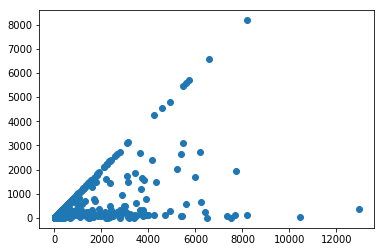

In [108]:
plt.scatter(bp_exon_row_meta_with_gene["exon length"].values, 
            bp_exon_row_meta_with_gene["cds length"].values)
plt.show()

In [149]:
VarFile = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014LGD.xlsx")
ASD_high_conf_df_ = [x.strip() for x in open(ASD_high_conf, 'rt')]
VarFile = VarFile[VarFile["effectGene"].isin(ASD_high_conf_df_)]
VarFile.loc[VarFile["effectGene"]=="KMT2E", "effectGene"] = "MLL5" #MLL5 
VarFile.loc[VarFile["effectGene"]=="SKIDA1", "effectGene"] = "C10orf140" #MLL5 
VarFile.loc[VarFile["effectGene"]=="KMT2A", "effectGene"] = "MLL" #MLL5 #
VarFile.loc[VarFile["effectGene"]=="KMT2C", "effectGene"] = "MLL3" #MLL5 
wigler_fam_info = pd.read_excel("/Users/jiayao/Work/BrainDisorders/data/nature13908-s2/Supplementary_Table_1.xlsx")
famID2Gender = dict(zip(wigler_fam_info["familyId"].values, wigler_fam_info["probandGender"].values))
famID2VIQ = dict(zip(wigler_fam_info["familyId"].values, wigler_fam_info["probandVIQ"].values))
famID2NVIQ = dict(zip(wigler_fam_info["familyId"].values, wigler_fam_info["probandNVIQ"].values))

In [151]:
VarFile.head(2)

,familyId,location,variant,vcfVariant,inChild,fromParent,effectGene,effectType,familyDescription
7,13545,20:49509095,ins(T),20:49509094:G:GT,pM,NaN,ADNP,frame-shift,pM
8,12130,20:49510028,del(2),20:49510027:CTT:C,pF,NaN,ADNP,frame-shift,pF


In [154]:
Jiayao_features = pd.read_csv("unifiedmodel/features.65.jiayao.csv")
RecLGDGeneSet = set(Jiayao_features["effectGene"].values)
#RecLGDGeneSet.remove("MLL5")
#RecLGDGeneSet.remove("TCF7L2")
#RecLGDGeneSet.remove("RIMS1")
#RecLGDGeneSet.remove("GIGYF1")
#RecLGDGeneSet.remove("KDM5B")

In [157]:
mg = mygene.MyGeneInfo()
HighConfGeneSet = set(VarFile["effectGene"].values)
#geneIDs = mg.querymany(geneList, scopes="symbol", fields="ensembl.gene", species="human")
GeneSet = RecLGDGeneSet.union(HighConfGeneSet)
GeneList = list(GeneSet)
print(len(GeneList))

103


In [159]:
#SubSetBrainSpanData(GeneSet)

In [6]:
for i, row in VarFile.iterrows():
    famid, gene, (Chr, Pos, Ref, Alt) = row["familyId"], row["effectGene"], row["vcfVariant"].split(":")
    exonId = searchExon_BrainSpan(gene, Chr, Pos, Ref, Alt, bp_exon_row_meta, bp_exon_col_meta)
    VarFile.loc[i, "ExonID"] = exonId
    VarFile.loc[i, "Gender"] = famID2Gender[famid]
    VarFile.loc[i, "VIQ"] = famID2VIQ[famid]
    VarFile.loc[i, "NVIQ"] = famID2NVIQ[famid]

In [7]:
VarFile.head(2)
VarFile.to_excel("./data/ProLGD_wilger2014_predicted.July20.xlsx",index=False)

In [8]:
VarFile.head(2)

,familyId,location,variant,vcfVariant,inChild,fromParent,effectGene,effectType,familyDescription,ExonID,Gender,VIQ,NVIQ
7,13545,20:49509095,ins(T),20:49509094:G:GT,pM,NaN,ADNP,frame-shift,pM,41150.0,M,23.0,38.0
8,12130,20:49510028,del(2),20:49510027:CTT:C,pF,NaN,ADNP,frame-shift,pF,41150.0,F,62.0,55.0


In [106]:
expdict_gene = ins.LoadGeneSetDataFromFil2("./data/qn.ProbandLGD_PRE.Regionsgt20.98Genes.GeneLog2Exp.csv")
expdict_exon = ins.LoadGeneSetDataFromFil("./data/qn.ProbandLGD_PRE.Regionsgt20.98Genes.GeneExonLog2Exp.csv")

In [107]:
PredictedLGDGeneSet = set(VarFile["effectGene"].values)
bp_exon_row_meta_with_gene = bp_exon_row_meta[bp_exon_row_meta["gene_symbol"].isin(PredictedLGDGeneSet)]

In [12]:
exonPartition = pd.read_csv("/Users/jiayao/Work/BrainDisorders/data/Andy-brainspan/PartitionExons_v2_byq.csv")

AndyGeneSet = set([x.split("_")[0] for x in exonPartition["exon_id"].values])
ExonID2Part = dict(zip(exonPartition["exon_id"].values, exonPartition["group_id"].values))
PredictedLGDGeneSet.difference(AndyGeneSet)
AndyGeneSet.difference(PredictedLGDGeneSet)
exonPartition.head(2)

,exon_id,group_id
0,THSD7A_1,a
1,THSD7A_14,a


In [26]:
Exon_Coord = pd.read_csv("../data/Andy-brainspan/BrainSpan_RNAseq_Gencode_Exon_Coordinates.flat", 
    delimiter="\t")
Exon_Coord.head(2)
Exon_Coord["length"] = Exon_Coord["end_post"] - Exon_Coord["start_post"]
ExonID2Length = dict(zip(Exon_Coord["exon_id"].values, Exon_Coord["length"].values))

In [110]:
#Genes = list(PredictedLGDGeneSet)
#Genes = list(RecLGDGeneSet)
Genes = list(AndyGeneSet)
ExonPool = PoolTheExons(ins, expdict_gene, expdict_exon, VarFile, Genes, bp_exon_row_meta_with_gene, ExonID2Length,
                       minLog2RPKMplus1Cut = 0)

/Users/jiayao/Work/BrainDisorders/src/utils.py:3283: RuntimeWarning: divide by zero encountered in double_scalars
  self.relbias = np.mean(self.exonExp[:6]) / np.mean(self.exonExp[6:])


In [111]:
ExonPool.sort(key=lambda x: x.relbias)

In [127]:
parts = [[],[],[],[]]
for exon in ExonPool:
    if ExonID2Part[exon.ID2] == 'd':
        parts[0].append(exon)
    elif ExonID2Part[exon.ID2] == 'c':
        parts[1].append(exon)
    elif ExonID2Part[exon.ID2] == 'b':
        parts[2].append(exon)
    elif ExonID2Part[exon.ID2] == 'a':
        parts[3].append(exon)

In [128]:
MyExonIDSet = []
for exon in ExonPool:
    MyExonIDSet.append(exon.ID2)
MyExonIDSet = set(MyExonIDSet)
AndyExonIDSet = set(exonPartition["exon_id"].values)

In [129]:
print(AndyExonIDSet.difference(MyExonIDSet))
print(MyExonIDSet.difference(AndyExonIDSet))

set()
set()


In [115]:
"""dat = [x.relbias for x in ExonPool if x.relbias < 10]
print(dat[:10])
dat = np.array(dat)
dat = dat[~np.isnan(dat)]
print(max(dat), min(dat))
plt.hist(dat, bins=100)
#plt.xlim(-2,2)
plt.show()"""

'dat = [x.relbias for x in ExonPool if x.relbias < 10]\nprint(dat[:10])\ndat = np.array(dat)\ndat = dat[~np.isnan(dat)]\nprint(max(dat), min(dat))\nplt.hist(dat, bins=100)\n#plt.xlim(-2,2)\nplt.show()'

In [122]:
"""
parts = []
step = int(len(ExonPool)/4)
print (step)
ExonPool = sorted(ExonPool, key=lambda x: x.relbias)
for i in range(3):
    print( i*step,(i+1)*step)
    parts.append(ExonPool[i*step:(i+1)*step])
print (3*step, len(ExonPool))
parts.append(ExonPool[3*step:])
for i in range(4):
    #print i, min([x.relbias for x in parts[i]]), max([x.relbias for x in parts[i]])
    print (i, parts[i][0].relbias, parts[i][-1].relbias)
    #, min([x.relbias for x in parts[i]]), max([x.relbias for x in parts[i]])
"""

549
0 549
549 1098
1098 1647
1647 2199
0 0.0 1.0396386470217556
1 1.0407322428645842 1.2343582166554554
2 1.2348390909187341 1.5465799265831712
3 1.5465988125830905 10


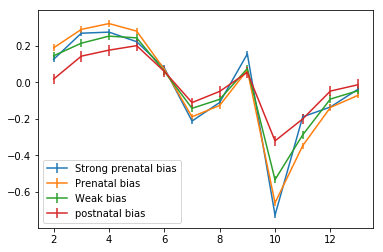

In [130]:
#ExonPool = sorted(ExonPool, key=lambda x: x.relbias, reverse=True)

labels = ["Strong prenatal bias","Prenatal bias","Weak bias","postnatal bias"]
for i in range(4):
    allexonexp = []
    for exon in parts[i]:
        allexonexp.extend(exon.exonExp)
    Mean = np.mean(allexonexp)
    AvgExps, Errbars = [],[]
    for j,stage in enumerate(Stages):
        values = [x.exonExp[j] for x in parts[i]]
        AvgExp = math.log2(np.mean(values)/Mean)
        Errbar = np.std([math.log2(x/Mean+1) for x in values])/math.sqrt(len(values))
        AvgExps.append(AvgExp)
        Errbars.append(Errbar)
    plt.errorbar(range(2,14), AvgExps, Errbars, label=labels[i])
plt.legend()

In [131]:
TotalCDS = sum([x.CDSLength for x in ExonPool])
#TotalHit = len([x for x in ExonPool if x.hitted == True])
#print (TotalCDS, TotalHit)

In [132]:
print("Rate\tP")
Rates = []
OveralRate = 0
TotalMuts = 0
TotalCDS = 0
for i in range(4):
    P = sum([x.CDSLength for x in parts[i]])/TotalCDS
    withLGD = sum([x.Nmut for x in parts[i]])
    TotalMuts += withLGD
    Rates.append(withLGD/sum([x.CDSLength for x in parts[i]]))
    TotalCDS += sum([x.CDSLength for x in parts[i]])
    print(withLGD/sum([x.CDSLength for x in parts[i]]))
OveralRate = TotalMuts/TotalCDS
print(OveralRate)

Rate	P
0.0003580581938790894
0.00019780540112853187
0.00024845822796042415
0.00022276549076951198
0.0002530875662568961


/Users/jiayao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


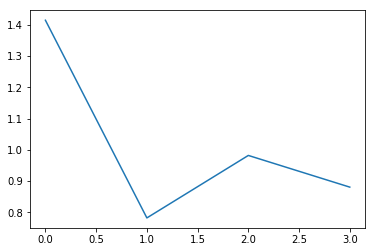

In [136]:
normedRate = []
for Rate, group in zip(Rates, ["Strong prenatal bias","Prenatal bias","Weak bias","postnatal bias"]):
    xx = Rate/OveralRate
    normedRate.append(xx)
plt.plot(normedRate)
plt.show()

In [138]:
print("Rate\tP")
Rates0 = []
Rates1 = []
Rates2 = []
OveralRate0,OveralRate1,OveralRate2 = 0,0,0
TotalMuts0, TotalMuts1, TotalMuts2 = 0,0,0
TotalCDS = 0
for i in range(4):
    withLGD0 = sum([x.Nmut for x in parts[i]])
    withLGD1 = sum([x.Nmut for x in parts[i] if x.IQgt70])
    withLGD2 = sum([x.Nmut for x in parts[i] if x.IQlt70])
    
    TotalMuts0 += withLGD0
    TotalMuts1 += withLGD1
    TotalMuts2 += withLGD2
    
    Rates0.append(withLGD0/sum([x.CDSLength for x in parts[i]]))
    Rates1.append(withLGD1/sum([x.CDSLength for x in parts[i]]))
    Rates2.append(withLGD2/sum([x.CDSLength for x in parts[i]]))
    
    TotalCDS += sum([x.CDSLength for x in parts[i]])
    #print(withLGD/sum([x.CDSLength for x in parts[i]]))
OveralRate0 = TotalMuts0/TotalCDS
OveralRate1 = TotalMuts1/TotalCDS
OveralRate2 = TotalMuts2/TotalCDS
print(OveralRate)


Rate	P
0.0002530875662568961


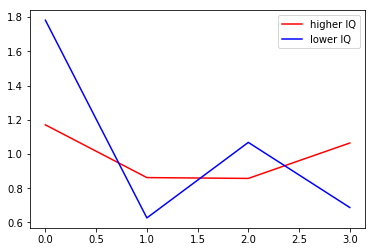

In [143]:
normedRate1 = []
normedRate2 = []
for Rate, group in zip(Rates1, ["Strong prenatal bias","Prenatal bias","Weak bias","postnatal bias"]):
    xx = Rate/OveralRate1
    normedRate1.append(xx)
for Rate, group in zip(Rates2, ["Strong prenatal bias","Prenatal bias","Weak bias","postnatal bias"]):
    xx = Rate/OveralRate2
    normedRate2.append(xx)
plt.plot(normedRate1, color="red", label="higher IQ")
plt.plot(normedRate2, color="blue", label="lower IQ")
plt.legend()
plt.show()

In [51]:
from biomart import BiomartServer
server = BiomartServer( "http://www.ensembl.org/biomart/martservice" )
# set verbose to True to get some messages
server.verbose = True

In [52]:
JonCDS = pd.read_csv("../data/Jon-GTEx/cds-pred-lgd-jc.csv")

In [53]:
JonCDS.head(2)

,ensembl_gene_id,genomic_coding_start,genomic_coding_end,cds_start,cds_end,entrezgene
0,ENSG00000095564,93683834,93683847,1,14,9044
1,ENSG00000095564,93695414,93695537,15,138,9044


In [55]:
len(set(JonCDS["ensembl_gene_id"].values))

108

In [54]:
bp_exon_row_meta_with_gene.head(2)

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,EXONID2
1248,1249,1086943,ENSG00000005108,THSD7A,221981.0,11410063,11415505,5442,5442,THSD7A_1
1249,1250,1086943,ENSG00000005108,THSD7A,221981.0,11416196,11416284,88,88,THSD7A_2


In [59]:
bp_exon_row_meta_with_gene = MatchCDS3(JonCDS, bp_exon_row_meta_with_gene)

In [60]:
bp_exon_row_meta_with_gene.head(2)

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,EXONID2,cds_length_3
1248,1249,1086943,ENSG00000005108,THSD7A,221981.0,11410063,11415505,5442,5442,THSD7A_1,85.0
1249,1250,1086943,ENSG00000005108,THSD7A,221981.0,11416196,11416284,88,88,THSD7A_2,88.0


In [74]:
bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["cds_length_3"]==np.nan]

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,EXONID2,cds_length_3


In [75]:
bp_exon_row_meta_with_gene["cds_length_3"].values

array([ 85.,  88., 211., ...,  nan,  nan,  nan])

In [92]:
D = [exon.ID2 for exon in parts[3]]
test = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["EXONID2"].isin(D)]
test[test["exon length"]>3000]

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,EXONID2,cds_length_3
1248,1249,1086943,ENSG00000005108,THSD7A,221981.0,11410063,11415505,5442,5442,THSD7A_1,85.0
6711,6712,1087275,ENSG00000021574,SPAST,6683.0,32379442,32382706,3264,3264,SPAST_17,123.0
8748,8749,1087398,ENSG00000036257,CUL3,8452.0,225334866,225339093,4227,4227,CUL3_1,132.0
11539,11540,1087537,ENSG00000049618,ARID1B,57492.0,157469757,157473538,3781,3781,ARID1B_11,328.0
11551,11552,1087537,ENSG00000049618,ARID1B,57492.0,157527300,157530401,3101,3101,ARID1B_23,1725.0
13098,13099,1087620,ENSG00000055332,EIF2AK2,5610.0,37326352,37334538,8186,8186,EIF2AK2_1,123.0
16219,16220,1087806,ENSG00000065526,SPEN,23013.0,16254585,16262761,8176,8176,SPEN_12,8176.0
26745,26746,1088376,ENSG00000080603,SRCAP,10847.0,30748369,30752028,3659,3659,SRCAP_34,2685.0
39044,39045,1089161,ENSG00000100354,TNRC6B,23112.0,40718857,40731811,12954,12954,TNRC6B_31,388.0
40539,40540,1089276,ENSG00000100852,ARHGAP5,394.0,32623215,32628934,5719,5719,ARHGAP5_11,328.0


In [93]:
13717573 - 13715720

1853